In [1]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from joblib import Parallel, delayed
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#from utils import * # We've added all the functions from the last BLU to the utils.py 
import seaborn as sns

import numpy as np
from random import gauss
from random import seed
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 4)



# Read and Import all Data

In [2]:
###train and test must be in the form of sereies so if we have a data frame we need to choose a column of it
# concatenate train and test
#df_ = pd.concat([train, test], axis=0)
#read data
dataset = 'df_wf3'
dataset1='data/wf3_data.csv'
#df_ = pd.read_csv(os.path.join('data',dataset + ".csv"))  
#df_ = pd.read_csv('data/wf1_data.csv')
#df = df_.copy()

#df_ = pd.read_csv('data/wf2_data.csv')
#df = df_.copy()

df_ = pd.read_csv(dataset1)
df= df_.copy()



df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')#, infer_datetime_format=True)
df = df.set_index('date')
df = df.sort_index()
df
# then seperate train and test set

,wp,ws
date,,
2009-07-01 01:00:00,0.105,3.81
2009-07-01 02:00:00,0.033,3.68
2009-07-01 03:00:00,0.022,3.66
2009-07-01 04:00:00,0.039,3.70
2009-07-01 06:00:00,0.105,3.66
...,...,...
2010-06-30 19:00:00,NaN,6.75
2010-06-30 20:00:00,NaN,6.20
2010-06-30 21:00:00,NaN,5.61


In [3]:
df.isnull().sum()

wp    24
ws     0
dtype: int64

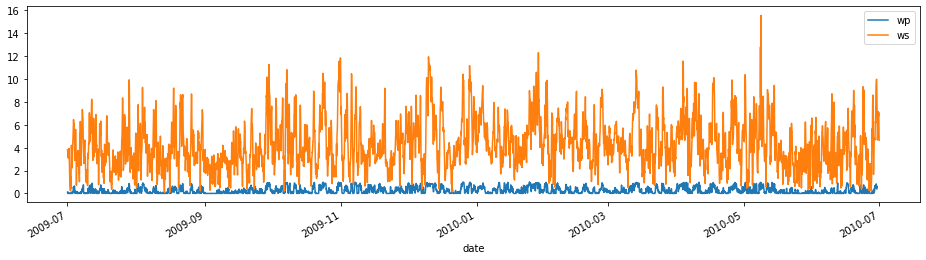

In [4]:
df.plot()
plt.rcParams["figure.figsize"] = (20,20)

# Data Preprocessing(Feature engineering)

<AxesSubplot:xlabel='date'>

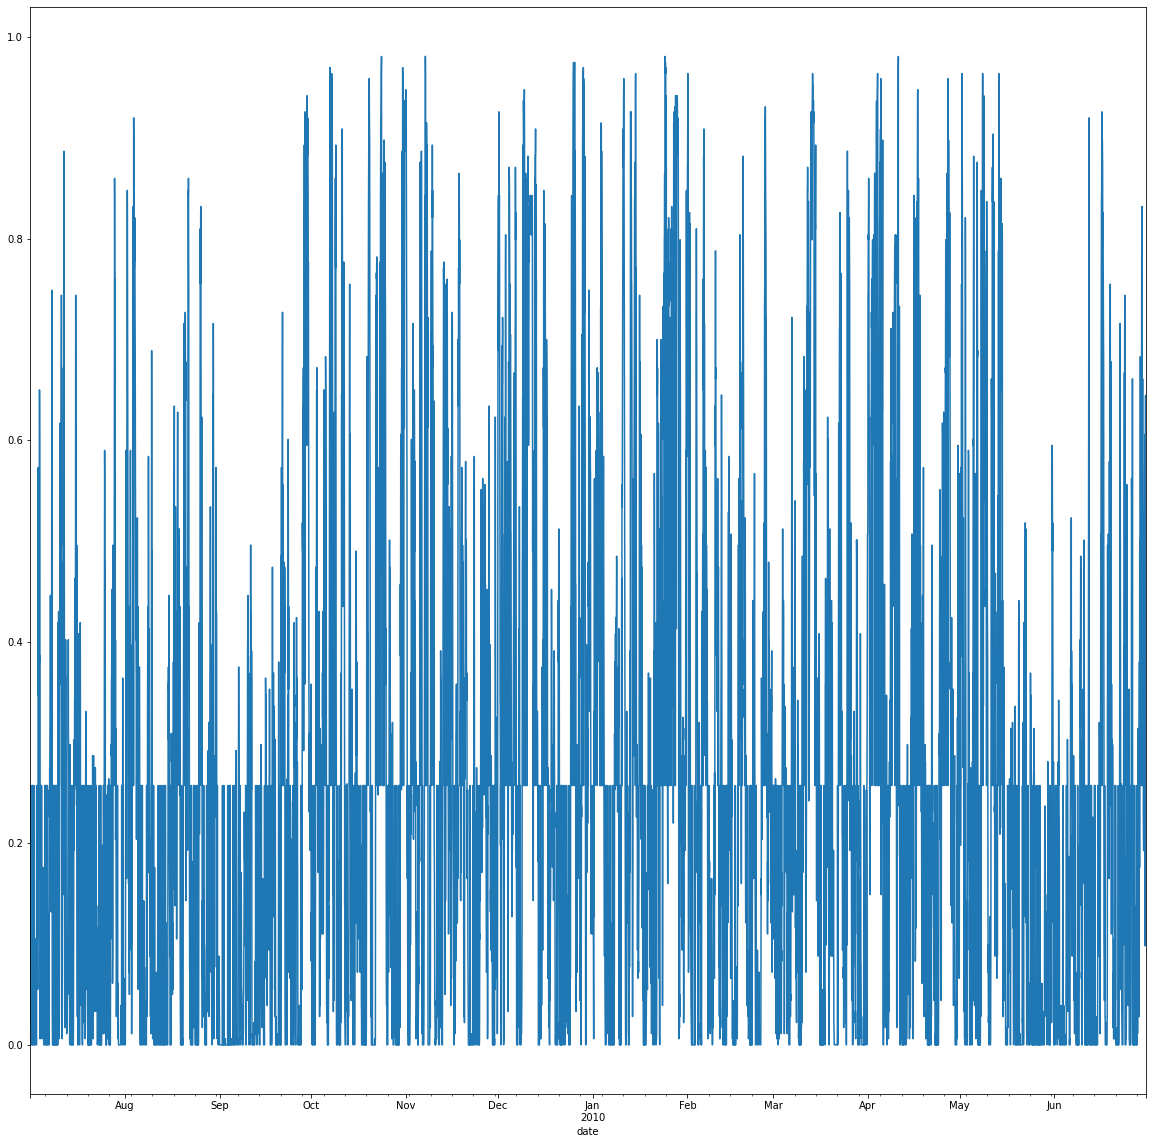

In [5]:
#filling the missing dates with zero and choosing one column to have series
df = df.resample('H').asfreq()#asfreq() put all the new rows nan value
#df_resampled = df.resample('D').mean()   #can be 'M','D','Y','W' or even df.resample('5 min').sum().plot()
df.isnull().sum()
#df_cleaned = df_resampled.fillna(0)
#df_cleaned = df_cleaned.customers
###filling the missing value with the method of forward fill
#df['wp'].fillna(method='ffill').plot() #we can plot it also
#filling the missing value with KNN imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
data_imputed = imputer.fit_transform(df) # This may take a bit to run
df= pd.DataFrame(data_imputed, index=df.index, columns=df.columns)
df.wp.interpolate().plot() # we can plot it


In [6]:
df.isnull().sum()

wp    0
ws    0
dtype: int64

In [7]:
#adding day weekday etc to data frame
df['day'] = df.index.day
df['month'] = df.index.month
#df['year'] = df['date'].dt.year
df['hour'] = df.index.hour
#df['minute'] = df['date'].dt.minute
#df['second'] = df['date'].dt.second
#df['day of the week'] = df['date'].dt.weekday
#df['day of the week name'] = df['date'].dt.day_name()
#df['quarter'] = df['date'].dt.quarter
#df['is it a leap year?'] = df['date'].dt.is_leap_year

#compute comulative sum
#df.index.day
df

,wp,ws,day,month,hour
date,,,,,
2009-07-01 01:00:00,0.105000,3.810000,1,7,1
2009-07-01 02:00:00,0.033000,3.680000,1,7,2
2009-07-01 03:00:00,0.022000,3.660000,1,7,3
2009-07-01 04:00:00,0.039000,3.700000,1,7,4
2009-07-01 05:00:00,0.257337,4.338232,1,7,5
...,...,...,...,...,...
2010-06-30 19:00:00,0.644600,6.750000,30,6,19
2010-06-30 20:00:00,0.455200,6.200000,30,6,20
2010-06-30 21:00:00,0.223800,5.610000,30,6,21


# Feature engineering (adding more features to  data frame)

In [8]:
#diff
#df['diff'] = df.wp.diff().fillna(0)
#Rolling windows
df['rolling_max'] = df['wp'].rolling('24h').max().fillna(0)
df['rolling_min'] = df['wp'].rolling('24h').min().fillna(0)
df['rolling_mean'] = df['wp'].rolling('24h').mean().fillna(0)
df['rolling_std'] = df['wp'].rolling('24h').std().fillna(0)
#add Holiday if it is 1 and if it is not 0
#holidays = df_cleaned[((df_cleaned.index.month==12) & (df_cleaned.index.day==25))
            #  |((df_cleaned.index.month==1) & (df_cleaned.index.day==1))].customers
#df_cleaned['holidays'] = holidays + 1
#df_cleaned['holidays'] = df_cleaned['holidays'].fillna(0)
#day of week and month
#df_cleaned['day_of_week'] = df_cleaned.index.weekday
#df_cleaned['month'] = df_cleaned.index.month
#Circular encoding

#df_cleaned['sin_weekday'] = np.sin(2*np.pi*df_cleaned.index.weekday/7)
#df_cleaned['cos_weekday'] = np.cos(2*np.pi*df_cleaned.index.weekday/7)
        
#df_cleaned['sin_month'] = np.sin(2*np.pi*df_cleaned.index.month/12)
#df_cleaned['cos_month'] = np.cos(2*np.pi*df_cleaned.index.month/12)
#df_cleaned = df_cleaned.drop(['day_of_week','month'], axis=1)

df.head()

,wp,ws,day,month,hour,rolling_max,rolling_min,rolling_mean,rolling_std
date,,,,,,,,,
2009-07-01 01:00:00,0.105000,3.810000,1,7,1,0.105000,0.105,0.105000,0.000000
2009-07-01 02:00:00,0.033000,3.680000,1,7,2,0.105000,0.033,0.069000,0.050912
2009-07-01 03:00:00,0.022000,3.660000,1,7,3,0.105000,0.022,0.053333,0.045081
2009-07-01 04:00:00,0.039000,3.700000,1,7,4,0.105000,0.022,0.049750,0.037500
2009-07-01 05:00:00,0.257337,4.338232,1,7,5,0.257337,0.022,0.091267,0.098352


# If we have multi index

In [9]:

#data.set_index(['col1','col2'])
#data.sort_index()
#group by multi index
#food.groupby(level='Product').Price.idxmin()
#selecting from multi index
#Selecting from multi-index: dataframe.loc[idx[index_level_0, index_level_1], columns]
#idx = pd.IndexSlice
#data.loc[idx[:,'msft'],:]
#how to get indexes
#data.loc[data.index.get_level_values(0).day_name()=='Monday'].Close.mean()
#percentage change
#data.sort_index(level=['Stock', 'Date']).Close.pct_change().head()
# group by the stock, and then take the Close, and calculate percentage change 
#data.groupby(level='Stock').Close.pct_change().head()
#Put one of the multi-index level into columns: unstack()
# group by using lambda function
#food.groupby(level='Product').Price.agg(lambda x: list(x.loc[x == x.min()].index))

# Scatter plot

In [10]:
# scatter plot of one column with respect to another one
#plt.scatter(data['thousands of passengers'], data.lag_1)

# Correlation between one coulumns with its lags

In [11]:
# It needs resample .asfriq in advance to fill the missing date with nans and then those nans will be ignored by corr function
#cor_df = df.corr()
#lower_triangle_mask = np.triu(np.ones(cor_df.shape)).astype(np.bool)
#cor_df_lower = cor_df.mask(lower_triangle_mask)
#plt.figure(figsize = (12,8))
#sns.heatmap(cor_df_lower, annot = True, cmap = "RdBu_r")


# Seasonal decomposition in time series

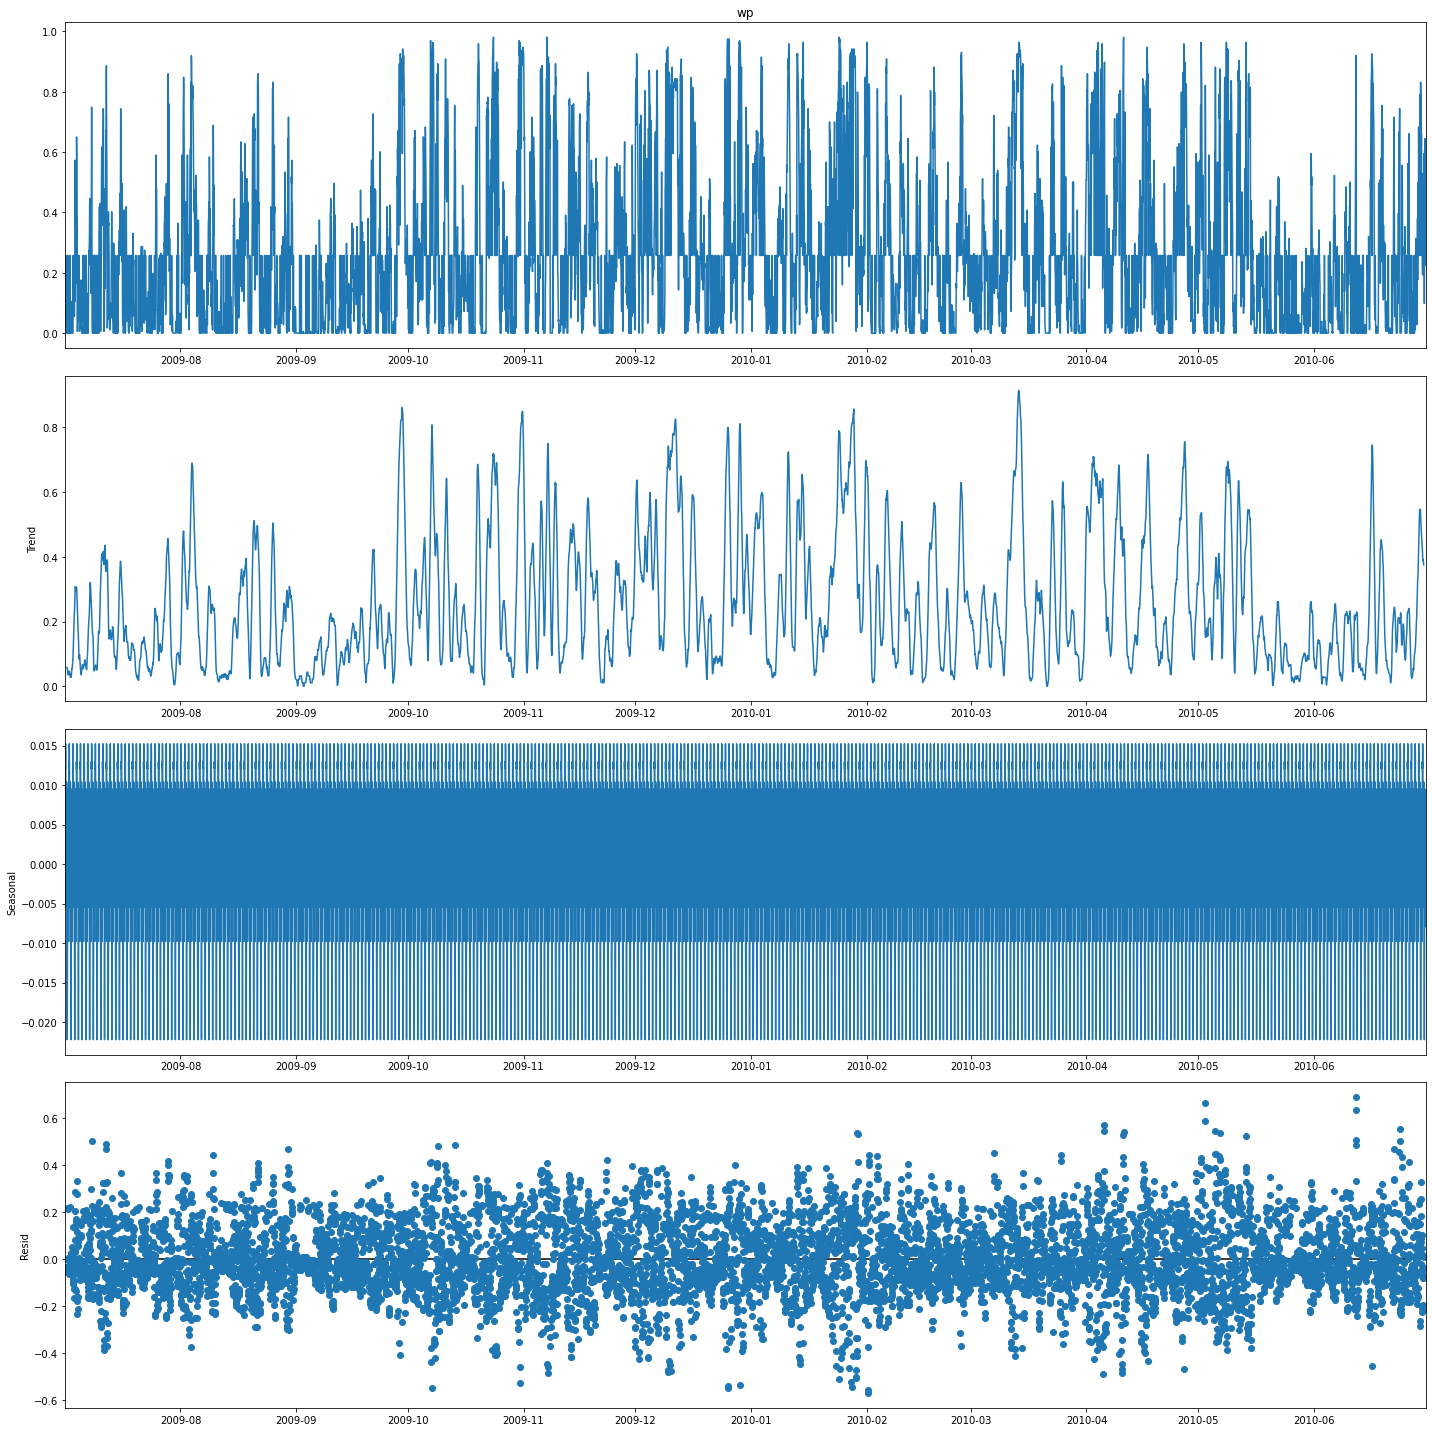

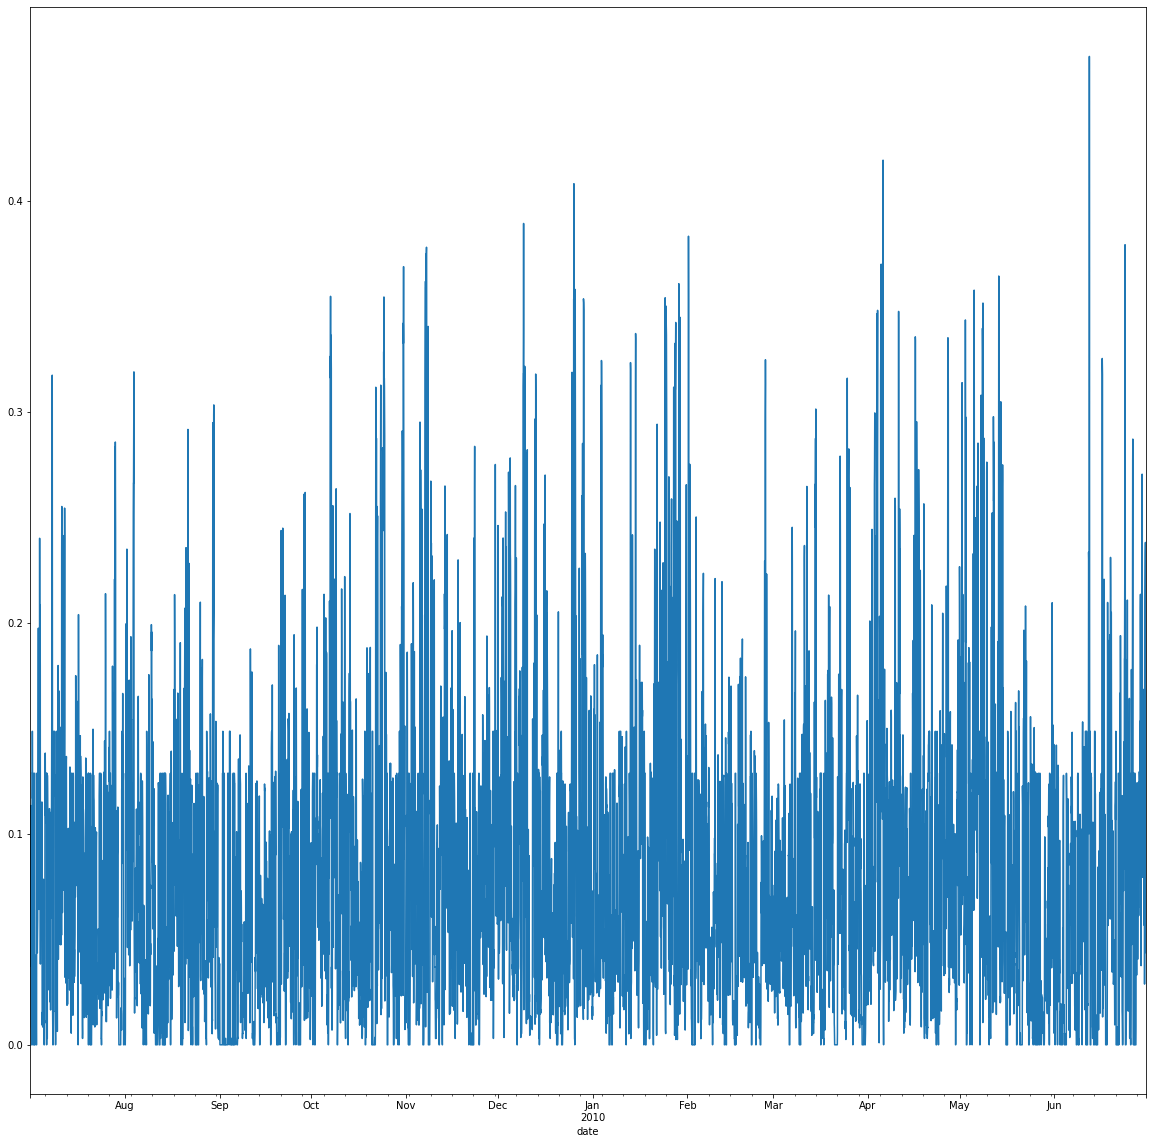

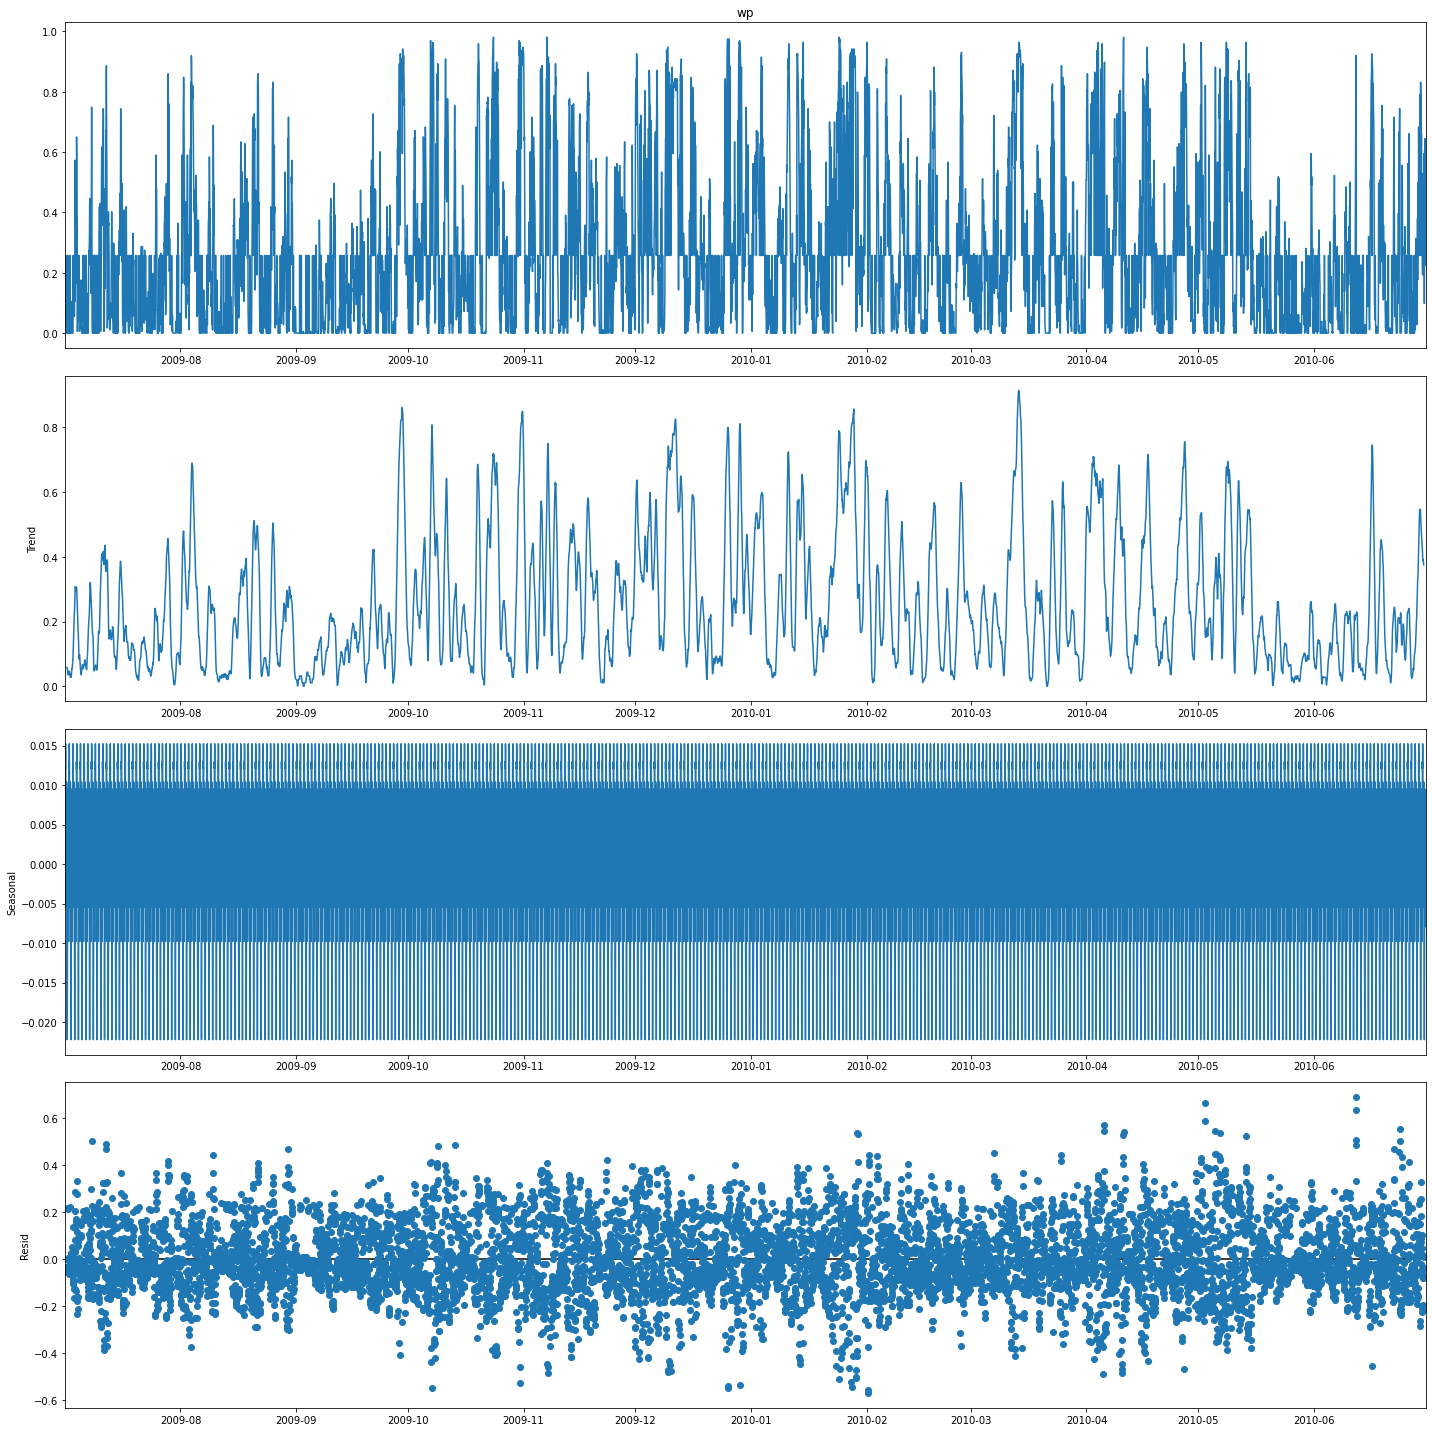

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
#To choose modell aditive or multiplicetive we have to plot the follwing:
df.wp.rolling(4).std().plot();#24 is seasonal.It can be different
#If variance increasing model = Multiplicative if variance is constant model = additive
decomposition = seasonal_decompose(df.wp, model='additive')
decomposition.plot()
#To see the head of seasonal , trend , ... data



# ACF

In [13]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
acf(df['wp'])
acf(df['ws'])

array([1.        , 0.88658345, 0.83767288, 0.77824153, 0.71422368,
       0.65575626, 0.60212068, 0.55080743, 0.50315446, 0.45863881,
       0.41936374, 0.3887411 , 0.35869272, 0.33966592, 0.31761613,
       0.30247879, 0.29034575, 0.28607085, 0.28206038, 0.28131359,
       0.28296364, 0.28932704, 0.29057828, 0.28886884, 0.28077469,
       0.2639248 , 0.23742081, 0.21151468, 0.18241734, 0.15460226,
       0.12649906, 0.10220546, 0.08186098, 0.06523134, 0.05173447,
       0.04129365, 0.03360889, 0.03017033, 0.02765889, 0.02992886,
       0.03606371])

# Plot ACF

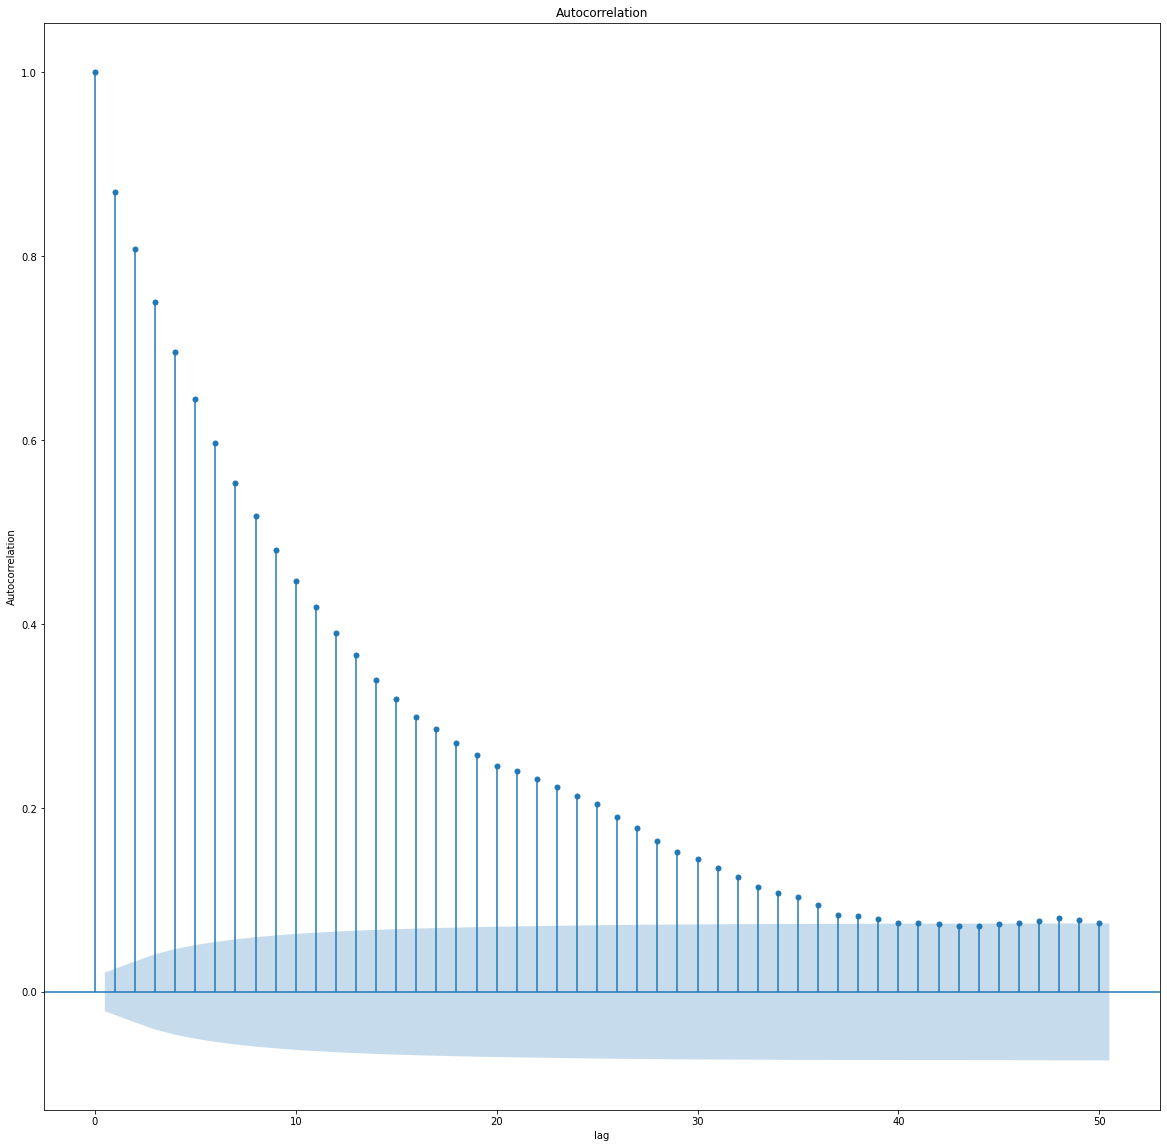

In [14]:
# with 95% confidence interval.(this is beacause of alpha = 0.5)
plot_acf(df['wp'], alpha=.05,lags=50)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF

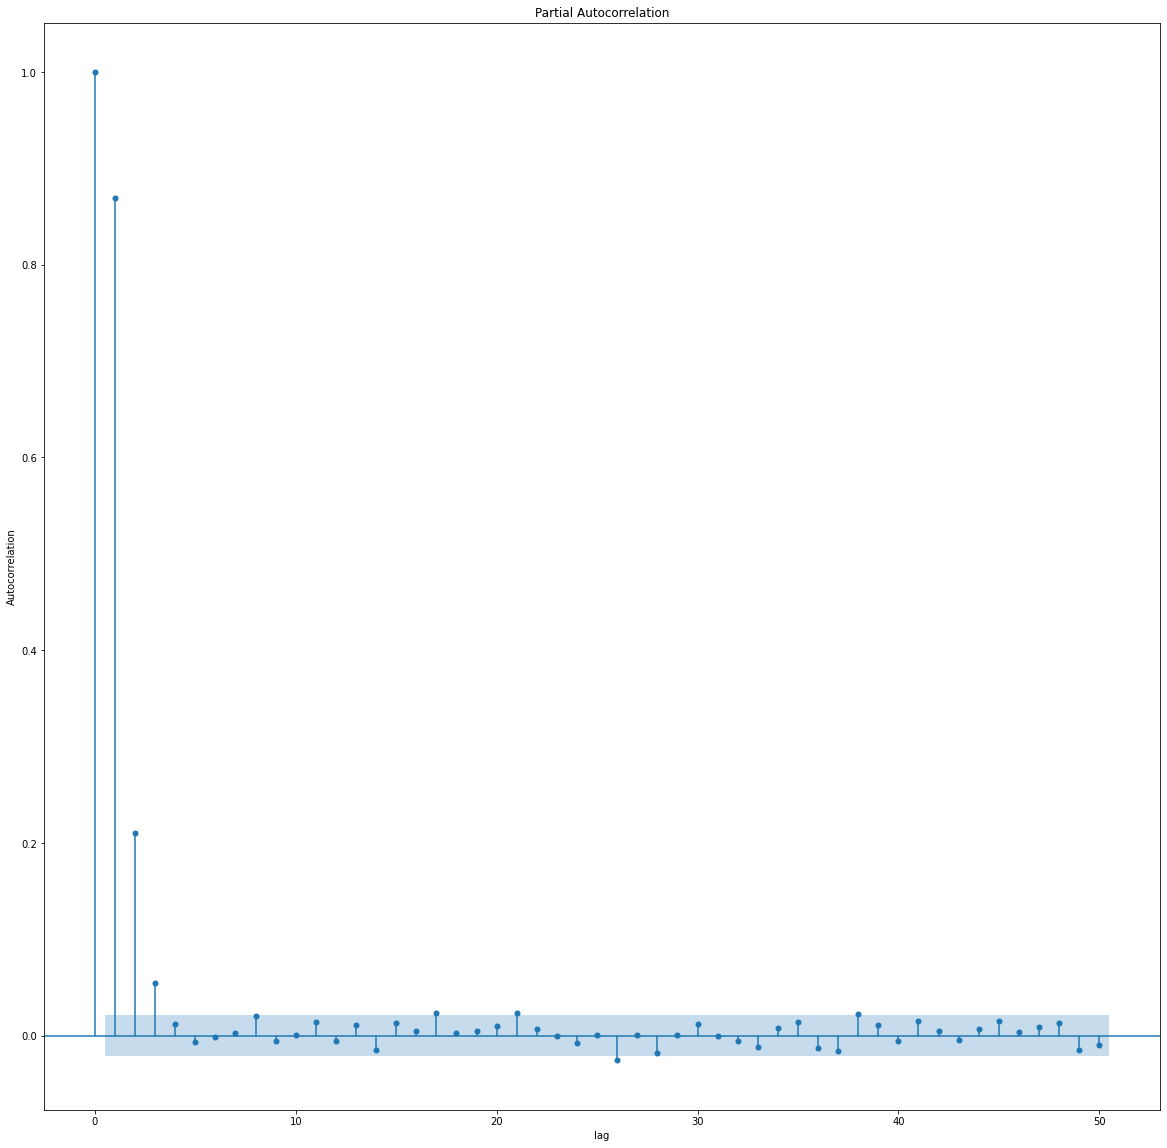

In [15]:
plot_pacf(df['wp'], alpha=0.05, lags=50, method='ols')
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

# A stationary time series

In [16]:
#mean, variance, autocorrelation, etc. are all constant over time.
#1-stabilize variance
df['df_logg_wp']= df['wp'].map(np.log)
df['df_logg_ws'] = df['ws'].map(np.log)
#2-Removing Trend
#df_logg_diff = df_logg.diff()
df


,wp,ws,day,month,hour,rolling_max,rolling_min,rolling_mean,rolling_std,df_logg_wp,df_logg_ws
date,,,,,,,,,,,
2009-07-01 01:00:00,0.105000,3.810000,1,7,1,0.105000,0.1050,0.105000,0.000000,-2.253795,1.337629
2009-07-01 02:00:00,0.033000,3.680000,1,7,2,0.105000,0.0330,0.069000,0.050912,-3.411248,1.302913
2009-07-01 03:00:00,0.022000,3.660000,1,7,3,0.105000,0.0220,0.053333,0.045081,-3.816713,1.297463
2009-07-01 04:00:00,0.039000,3.700000,1,7,4,0.105000,0.0220,0.049750,0.037500,-3.244194,1.308333
2009-07-01 05:00:00,0.257337,4.338232,1,7,5,0.257337,0.0220,0.091267,0.098352,-1.357368,1.467467
...,...,...,...,...,...,...,...,...,...,...,...
2010-06-30 19:00:00,0.644600,6.750000,30,6,19,0.661000,0.0982,0.395589,0.158789,-0.439125,1.909543
2010-06-30 20:00:00,0.455200,6.200000,30,6,20,0.644600,0.0982,0.387014,0.149094,-0.787018,1.824549
2010-06-30 21:00:00,0.223800,5.610000,30,6,21,0.644600,0.0982,0.376131,0.151150,-1.497002,1.724551


# Evaluating stationarity(Dickey-Fuller test )

In [17]:
# Perform Dickey-Fuller test:Law pvalue mean the time series is stationary The p value must be less than alpha
from statsmodels.tsa.stattools import adfuller
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(df['wp'].dropna())
pvalue


2.9378322679401238e-30

In [18]:
df.to_csv('data/' + dataset  + '_out.csv', index=True)